# Developing functions for computing the FFDI drought factor via the KBDI

In [1]:
import xarray as xr

import numpy as np

from src.prepare_data import _open

import matplotlib.pyplot as plt

In [2]:
%load_ext lab_black

## Cluster

In [3]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "01:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dask daskboard link: http://10.6.23.24:8787/status


## Develop on some AGCD data

In [ ]:
prep_data = True

if prep_data:
    agcd = _open.AGCD(["precip", "tmax"], None, None)

    precip = agcd[["precip"]].sel(time=slice("1960", None)).chunk({"time": -1})
    precip.to_zarr("agcd_precip.zarr", mode="w")

    tmax = agcd[["tmax"]].sel(time=slice("1960", None)).chunk({"time": -1})
    tmax.to_zarr("agcd_tmax.zarr", mode="w")

precip = xr.open_zarr("agcd_precip.zarr")
tmax = xr.open_zarr("agcd_tmax.zarr")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask/array/core.py:4605: PerformanceWarning: Increasing number of chunks by factor of 23
  result = blockwise(


In [5]:
Mangalore = {"lon": 145.2, "lat": -36.9}

precip_test = (
    precip["precip"].sel(Mangalore, method="nearest").sel(time=slice("2010", "2014")).chunk({"time": -1})
)
tmax_test = (
    tmax["tmax"].sel(Mangalore, method="nearest").sel(time=slice("2010", "2014")).chunk({"time": -1})
)
precip_annual_test = (
    precip["precip"]
    .sel(Mangalore, method="nearest")
    .sel(time=slice("2010", "2014"))
    .resample(time="A")
    .sum()
    .mean("time")
)

## Calculate KBDI

In [6]:
precip_annual = (
    precip.sel(time=slice("2010", "2014")).resample(time="A").sum().mean("time")
).compute()

In [7]:
import dask.array as dsa
from dask.array.gufunc import apply_gufunc
from operator import getitem


def calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day=False):
    """
    Calculate the Keetch-Byram drought index, defined as:

        KBDI_n = KBDI_n-1 − Peff + ET

    Peff is the previous 24-hour rainfall amount, precip_n, decreased by an amount to allow
    for interception and/or runoff:

        Peff = precip_n - (interception/runoff)

    where the interception and/or runoff is approximated as the first 5 mm within consecutive
    days with nonzero rainfall.

    ET is the evapotransporation, estimated as:

        ET = (203.2 - KBDI_n-1) * (0.968 * exp(0.0875 * tmax_n-1 + 1.5552) - 8.3)
             -------------------------------------------------------------------- * 10 ** (-3)
                          1 + 10.88 * exp(-0.00173 * precip_annual)

    where tmax_n-1 is the previous day's max temperature and precip_annual is the mean annual
    rainfall.

    Parameters
    ----------
    precip : numpy array with shape [..., N]
        Array of daily precipitation with the last axes corresponding to the time dimension
    tmax : numpy array with shape [..., N]
        Array of max daily temperature with the last axes corresponding to the time dimension
    precip_annual : numpy array with shape [...]
        Array containing the mean annual rainfall. Usually this is computed as the average over
        a period of years corresponding the calculation period of the KBDI
    use_precip_from_previous_day : boolean, optional
        If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
        KBDI_n. See Notes below.

    Notes
    -----
    Daily values represent different things in different datasets. For example:
      - the daily precipitation values in AGCD represent the previous 24-hour rainfall at 9am
        and the daily tmax/tmin values represent the max/min temperatures over the subsequent
        24-hours from 9am. Thus it is appropriate to use precip_n and t_max_n-1 as above in
        order to calculate KBDI_n from the previous 24-hour rainfaill and previous day's max
        temperature.
      - both the daily precipitation and daily max temperature values are assigned to 12pm on
        a given day in CAFE and correspond to the 24-hour period centred on that time. Thus,
        one could argue that it is appropriate to use precip_n-1 and t_max_n-1 (or precip_n
        and tmax_n) to calculate KBDI_n.
      - Daily reanalysis data (e.g. JRA55) is otfen referenced against the inital forecast
        time and the precip and tmax values correspond to the 24-hour period subsequent to the
        reference time. Thus, it is appropriate to use precip_n-1 and tmax_n-1 to calculate
        KBDI_n.

    References
    ----------
    Finkele et al. 2006 (on calculation):
        https://webarchive.nla.gov.au/awa/20060903105143/http://www.bom.gov.au/bmrc/pubs/researchreports/RR119.pdf
    Holgate et al. 2017 (on calculation):
        https://www.publish.csiro.au/wf/WF16217
    Dolling et al. 2005 (on initialisation):
        https://www.sciencedirect.com/science/article/pii/S0168192305001802#bib5
    """

    def _calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day):
        """Workhorse function to calculate the KBDI"""

        def calculate_Peff(precip, remaining_runoff):
            """
            Return Peff term in the KBDI and the remaining runoff from the daily
            rainfall
            """
            runoff_amount = 5
            if remaining_runoff is None:
                runoff = np.where(precip < runoff_amount, precip, runoff_amount)
                Peff = precip - runoff
                remaining_runoff = runoff_amount
            else:
                remaining_runoff = np.where(precip > 0, remaining_runoff, runoff_amount)
                runoff = np.where(precip < remaining_runoff, precip, remaining_runoff)
                Peff = precip - runoff
            return Peff, remaining_runoff - runoff

        def calculate_ET(KBDI_prev, tmax_prev, precip_annual):
            """
            Return evapotransporation (ET) term in the KBDI
            """
            term_1 = 203.2 - KBDI_prev
            term_2 = 0.968 * np.exp(0.0875 * tmax_prev + 1.5552) - 8.3
            term_3 = 1 + 10.88 * np.exp(-0.00173 * precip_annual)
            return 1e-3 * term_1 * term_2 / term_3

        def _calculate_KBDI_block(
            precip,
            tmax,
            precip_annual,
            KBDI_prev,
            precip_prev,
            tmax_prev,
            remaining_runoff,
            use_precip_from_previous_day,
            first_loop,
        ):
            """
            Returns the KBDI for a block of data
            """
            KBDI = np.zeros_like(precip)

            if use_precip_from_previous_day:
                if not first_loop:
                    Peff, remaining_runoff = calculate_Peff(
                        precip_prev, remaining_runoff
                    )
            else:
                Peff, remaining_runoff = calculate_Peff(
                    precip[..., 0], remaining_runoff
                )

            if not first_loop:
                ET = calculate_ET(KBDI_prev, tmax_prev, precip_annual)
                KBDI[..., 0] = KBDI_prev - Peff + ET

            for i in range(1, KBDI.shape[-1]):
                precip_curr = (
                    precip[..., i - 1]
                    if use_precip_from_previous_day
                    else precip[..., i]
                )
                Peff, remaining_runoff = calculate_Peff(precip_curr, remaining_runoff)
                ET = calculate_ET(KBDI[..., i - 1], tmax[..., i - 1], precip_annual)
                KBDI_curr = KBDI[..., i - 1] - Peff + ET
                KBDI[..., i] = np.where(KBDI_curr < 0, 0, KBDI_curr)

            return KBDI, remaining_runoff

        if isinstance(precip, dsa.core.Array):
            # Ensure precip_annual is also a dask array
            precip_annual = dsa.asarray(precip_annual, chunks=precip.chunks[:-1])

            KBDI = []
            KBDI_prev = dsa.empty_like(precip_annual)
            precip_prev = dsa.empty_like(precip_annual)
            tmax_prev = dsa.empty_like(precip_annual)
            remaining_runoff = dsa.empty_like(precip_annual)
            first_loop = True

            for block_idx in range(precip.blocks.shape[-1]):
                precip_block = precip.blocks[..., block_idx]
                tmax_block = tmax.blocks[..., block_idx]

                # Use apply_gufunc here because the function has multiple outputs with
                # different sizes. For simpler cases, map_blocks is probably easier and
                # more appropriate. I actually implemented map_blocks first here, see
                # https://github.com/dougiesquire/Squire_2022_CAFE-f6/blob/1d95b53349e6d3b06f858a746de0a4339c4b979c/notebooks/exploratory/calculate_KBDI.ipynb
                KBDI_block, remaining_runoff = apply_gufunc(
                    _calculate_KBDI_block,
                    "(i),(i),(),(),(),(),()->(i),()",
                    precip_block,
                    tmax_block,
                    precip_annual,
                    KBDI_prev,
                    precip_prev,
                    tmax_prev,
                    remaining_runoff,
                    axis=-1,
                    output_dtypes=[precip_block.dtype, precip_block.dtype],
                    **{
                        "use_precip_from_previous_day": use_precip_from_previous_day,
                        "first_loop": first_loop,
                    },
                )

                first_loop = False
                KBDI_prev = KBDI_block[..., -1]
                precip_prev = precip_block[..., -1]
                tmax_prev = tmax_block[..., -1]

                KBDI.append(KBDI_block)

            KBDI = dsa.concatenate(KBDI, axis=-1)
        else:
            KBDI, _ = _calculate_KBDI_block(
                precip,
                tmax,
                precip_annual,
                None,
                None,
                None,
                None,
                use_precip_from_previous_day,
                first_loop=True,
            )
        return KBDI

    KBDI = xr.apply_ufunc(
        _calculate_KBDI,
        precip,
        tmax,
        precip_annual,
        use_precip_from_previous_day,
        input_core_dims=[["time"], ["time"], [], []],
        output_core_dims=[["time"]],
        dask="allowed",
    )

    KBDI = KBDI.rename("KBDI")
    KBDI.attrs["long_name"] = "Keetch-Byram Drought Index (KBDI)"
    KBDI.attrs["standard_name"] = "Keetch-Byram Drought Index"

    return KBDI

In [20]:
from numba import jit
import dask.array as dsa
from dask.array.gufunc import apply_gufunc
from operator import getitem


def calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day=False):
    """
    Calculate the Keetch-Byram drought index, defined as:

        KBDI_n = KBDI_n-1 − Peff + ET

    Peff is the previous 24-hour rainfall amount, precip_n, decreased by an amount to allow
    for interception and/or runoff:

        Peff = precip_n - (interception/runoff)

    where the interception and/or runoff is approximated as the first 5 mm within consecutive
    days with nonzero rainfall.

    ET is the evapotransporation, estimated as:

        ET = (203.2 - KBDI_n-1) * (0.968 * exp(0.0875 * tmax_n-1 + 1.5552) - 8.3)
             -------------------------------------------------------------------- * 10 ** (-3)
                          1 + 10.88 * exp(-0.00173 * precip_annual)

    where tmax_n-1 is the previous day's max temperature and precip_annual is the mean annual
    rainfall.

    Parameters
    ----------
    precip : numpy array with shape [..., N]
        Array of daily precipitation with the last axes corresponding to the time dimension
    tmax : numpy array with shape [..., N]
        Array of max daily temperature with the last axes corresponding to the time dimension
    precip_annual : numpy array with shape [...]
        Array containing the mean annual rainfall. Usually this is computed as the average over
        a period of years corresponding the calculation period of the KBDI
    use_precip_from_previous_day : boolean, optional
        If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
        KBDI_n. See Notes below.

    Notes
    -----
    Daily values represent different things in different datasets. For example:
      - the daily precipitation values in AGCD represent the previous 24-hour rainfall at 9am
        and the daily tmax/tmin values represent the max/min temperatures over the subsequent
        24-hours from 9am. Thus it is appropriate to use precip_n and t_max_n-1 as above in
        order to calculate KBDI_n from the previous 24-hour rainfaill and previous day's max
        temperature.
      - both the daily precipitation and daily max temperature values are assigned to 12pm on
        a given day in CAFE and correspond to the 24-hour period centred on that time. Thus,
        one could argue that it is appropriate to use precip_n-1 and t_max_n-1 (or precip_n
        and tmax_n) to calculate KBDI_n.
      - Daily reanalysis data (e.g. JRA55) is otfen referenced against the inital forecast
        time and the precip and tmax values correspond to the 24-hour period subsequent to the
        reference time. Thus, it is appropriate to use precip_n-1 and tmax_n-1 to calculate
        KBDI_n.

    References
    ----------
    Finkele et al. 2006 (on calculation):
        https://webarchive.nla.gov.au/awa/20060903105143/http://www.bom.gov.au/bmrc/pubs/researchreports/RR119.pdf
    Holgate et al. 2017 (on calculation):
        https://www.publish.csiro.au/wf/WF16217
    Dolling et al. 2005 (on initialisation):
        https://www.sciencedirect.com/science/article/pii/S0168192305001802#bib5
    """

    @jit(nopython=True)
    def _calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day):
        """
        Workhorse function to calculate the KBDI
        
        Parameters
        ----------
        precip : numpy array with shape [..., N]
            Array of daily precipitation with the last axes corresponding to the time dimension
        tmax : numpy array with shape [..., N]
            Array of max daily temperature with the last axes corresponding to the time dimension
        precip_annual : numpy array with shape [...]
            Array containing the mean annual rainfall. Usually this is computed as the average over
            a period of years corresponding the calculation period of the KBDI
        use_precip_from_previous_day : boolean, optional
            If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
            KBDI_n.
            
        Note, I tried writing a version of this function using dask='allowed', rather than 
        dask='parallelized', which is generally a better approach. However, the code relied on hacks
        to use apply_gufunc or map_blocks, so I opted for this simpler approach instead.
        """

        def calculate_Peff(precip, remaining_runoff):
            """
            Return Peff term in the KBDI and the remaining runoff from the daily
            rainfall
            """
            runoff_amount = 5.0
            remaining_runoff = np.where(precip > 0, remaining_runoff, runoff_amount)
            runoff = np.where(precip < remaining_runoff, precip, remaining_runoff)
            Peff = precip - runoff
            return Peff, remaining_runoff - runoff

        def calculate_ET(KBDI_prev, tmax_prev, precip_annual):
            """
            Return evapotransporation (ET) term in the KBDI
            """
            term_1 = 203.2 - KBDI_prev
            term_2 = 0.968 * np.exp(0.0875 * tmax_prev + 1.5552) - 8.3
            term_3 = 1 + 10.88 * np.exp(-0.00173 * precip_annual)
            return 1e-3 * term_1 * term_2 / term_3

        KBDI = np.zeros_like(precip)

        if not use_precip_from_previous_day:
            Peff, remaining_runoff = calculate_Peff(
                precip[..., 0], np.zeros_like(precip[..., 0])
            )

        for i in range(1, KBDI.shape[-1]):
            precip_curr = (
                precip[..., i - 1] if use_precip_from_previous_day else precip[..., i]
            )
            Peff, remaining_runoff = calculate_Peff(precip_curr, remaining_runoff)
            ET = calculate_ET(KBDI[..., i - 1], tmax[..., i - 1], precip_annual)
            KBDI_curr = KBDI[..., i - 1] - Peff + ET
            KBDI[..., i] = np.where(KBDI_curr < 0, 0, KBDI_curr)

        return KBDI

    KBDI = xr.apply_ufunc(
        _calculate_KBDI,
        precip,
        tmax,
        precip_annual,
        use_precip_from_previous_day,
        input_core_dims=[["time"], ["time"], [], []],
        output_core_dims=[["time"]],
        dask="parallelized",
        output_dtypes=[precip.dtype],
    )

    KBDI = KBDI.rename("KBDI")
    KBDI.attrs["long_name"] = "Keetch-Byram Drought Index (KBDI)"
    KBDI.attrs["standard_name"] = "Keetch-Byram Drought Index"

    return KBDI

In [21]:
a = calculate_KBDI(
    precip["precip"].chunk({"time": -1}),
    tmax["tmax"].chunk({"time": -1}),
    precip_annual["precip"].compute(),
)

CPU times: user 204 ms, sys: 34.6 ms, total: 238 ms
Wall time: 2.25 s


(0.0, 200.0)

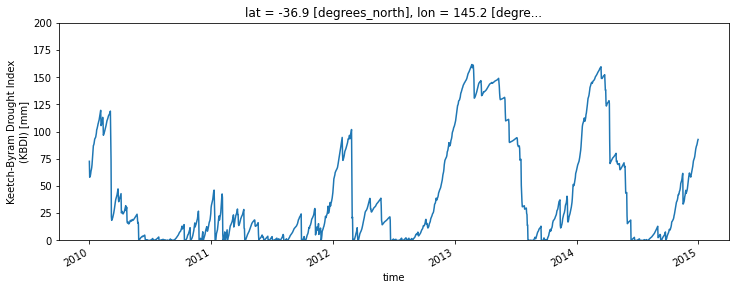

In [23]:
%%time
plt.figure(figsize=(12, 4))
a.sel(Mangalore, method="nearest").sel(time=slice("2010", "2014")).plot()
plt.ylim(0, 200)

In [24]:
a.isel(time=20).plot()

KeyboardInterrupt: 

In [327]:
a_test

<xarray.DataArray 'KBDI' (time: 1826)>
dask.array<getitem, shape=(1826,), dtype=float32, chunksize=(1826,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 -36.9
    lon      float32 145.2
  * time     (time) datetime64[ns] 2010-01-01T09:00:00 ... 2014-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Keetch-Byram Drought Index (KBDI)
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 Keetch-Byram Drought Index
    units:                         mm

In [173]:
a

<xarray.DataArray 'KBDI' (lat: 3, lon: 3, time: 1826)>
array([[[  0.       ,   2.2782767,   3.9880972, ..., 138.83308  ,
         139.92453  , 140.44579  ],
        [  0.       ,   2.0444171,   4.8404026, ...,  78.294815 ,
          79.48848  ,  80.16092  ],
        [  0.       ,   2.5298686,   3.7930396, ..., 164.48683  ,
         165.01454  , 165.3011   ]],

       [[  0.       ,   1.2000557,   2.7234757, ..., 130.02321  ,
         131.06598  , 131.64758  ],
        [  0.       ,   0.       ,   2.8748226, ...,  91.97268  ,
          91.19723  ,  91.487946 ],
        [  0.       ,   2.132575 ,   3.7043915, ..., 168.3652   ,
         168.95558  , 169.24109  ]],

       [[  0.       ,   0.       ,   2.2086709, ..., 108.08175  ,
         110.02614  , 111.19     ],
        [  0.       ,   0.       ,   0.       , ...,  18.204338 ,
          15.877833 ,  17.03597  ],
        [  0.       ,   0.       ,   1.1625805, ...,  90.46201  ,
          91.838844 ,  92.838264 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -34.6 -32.7 -36.9
  * lon      (lon) float32 146.4 148.2 145.2
  * time     (time) datetime64[ns] 2010-01-01T09:00:00 ... 2014-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Keetch-Byram Drought Index (KBDI)
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 Keetch-Byram Drought Index
    units:                         mm

In [134]:
a

<xarray.DataArray 'precip' (time: 1826)>
array([ 0.       ,  0.       ,  1.1625807, ..., 90.46202  , 91.83885  ,
       92.83827  ], dtype=float32)
Coordinates:
    lat      float32 -36.9
    lon      float32 145.2
  * time     (time) datetime64[ns] 2010-01-01T09:00:00 ... 2014-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm